In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.odr as odr
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [394]:
df = pd.read_csv('natgas.csv')
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df = df.drop('Dates', axis=1)
df_20 = df[df['Year'] == 2020]
np20 = df_20['Prices'].to_numpy()
df_21 = df[df['Year'] == 2021]
np21 = df_21['Prices'].to_numpy()
df_22 = df[df['Year'] == 2022]
np22 = df_22['Prices'].to_numpy()
df_23 = df[df['Year'] == 2023]
np23 = df_23['Prices'].to_numpy()
df_24 = df[df['Year'] == 2024]
np24 = df_24['Prices'].to_numpy()
lst = [df_20,df_21,df_22,df_23,df_24]

In [340]:
##conclude there is sig diff in prices
stats.f_oneway(np20,np21,np22,np23,np24)

F_onewayResult(statistic=14.278610601122846, pvalue=1.70458197611709e-07)

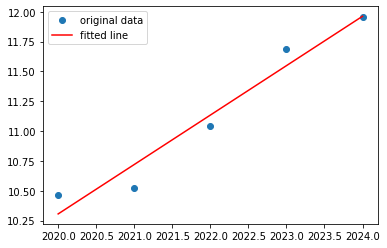

(0.4141111111111112,
 -826.1992222222225,
 0.005006576435711379,
 0.9740220796991917)

In [341]:
##try to model mean price growth
mean = []
year = []
for i in lst:
    mean.append(i['Prices'].mean())
    year.append(i['Year'].mean())
x,y = np.array(year),np.array(mean)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
slope,intercept,p_value,r_value

<AxesSubplot:xlabel='Month', ylabel='deviation'>

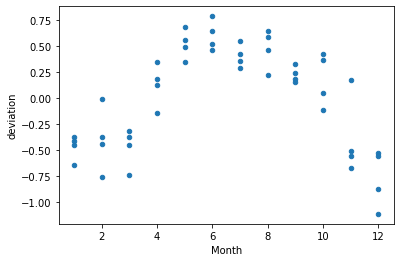

In [346]:
##model iter-year variation away from mean
mdf = pd.Series(mean,year)
df['yearly average'] = df['Year'].map(mdf)
df['deviation'] = df['yearly average'] - df['Prices']
df = df.sort_values(by='Month')
df.plot(x = 'Month', y = 'deviation', kind = 'scatter')


In [343]:
##normalize data
sc = StandardScaler()
nmonth = sc.fit_transform(df['Month'].to_numpy().reshape(-1,1)).squeeze()
ndev = sc.fit_transform(df['deviation'].to_numpy().reshape(-1,1)).squeeze()
nmonth.shape

(48,)

In [344]:
##sinouldal function fitting method
import numpy
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = numpy.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

Amplitude=1.4942313088129526, Angular freq.=inf, phase=0.0, offset=4.067729868238604, Max. Cov.=nan


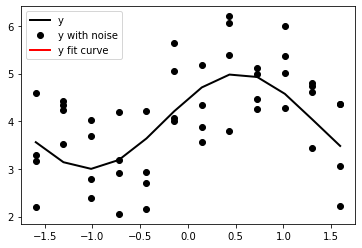

In [395]:
N, amp, omega, phase, offset, noise = 500, 1., 2., .5, 4., 3
tt = nmonth
tt2 =ndev
yy = amp*np.sin(omega*tt + phase) + offset
yynoise = yy + noise*(numpy.random.random(len(tt))-0.5)

res = fit_sin(tt, yynoise)

print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, yynoise, "ok", label="y with noise")
plt.plot(tt2, res["fitfunc"](tt2), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()